## Дз 7: "Metric learning"

## Цель задания:
Познакомится с алгоритмами metric learning
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу поиска похожего автомобиля в базе данных (автомобиля того же класса). На основе датасета [cars196](https://paperswithcode.com/sota/metric-learning-on-cars196) , ссылка на данные [мета](https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing) [data](https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing).

Процесс выполнения задания следующий:

0. Выбор модели эмбеддера:
    1. Выберите модель кодирующую изображения для выполнения домашнего задания. Любую, кроме модели resnet50.

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера).
    2. Добавьте аугментации в датасет **0.5 балла**.

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте train-loop для вашей модели и проведите обучение c Triplet loss **2 балла**.
    2. При формировании триплета не просто брать отрицательный класс, а воспользоваться техникой hard negative mining **0.5 балла**.
    3. Обучите модель и воcпользуйте иными loss функциями для задачи metric learning **0.5 балла**.
    4. Полезные ссылки [тык](https://github.com/KevinMusgrave/pytorch-metric-learning)
 
3. Валидация обученных моделей на тестовой выборке, вычисление метрики Recall и Precision
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрики поиска Recall@1, Recall@5, Precision@1, Precision@5. Обратите внимание, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта, а должны производить поиск на основе получившихся эмбеддингов (пример в [семинаре](metric_learning.ipynb) блок Faiss). **0.5 балла**
    2. При поиске воспользоваться библиотекой Faiss **0.5 балла**

4. Выводы:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.
    3. Проинтерпретируйте результаты работы модели с помощью [GradCam](https://github.com/jacobgil/pytorch-grad-cam)  **0.5 балла**




## Загрузим данные

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import scipy.io
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [4]:
ADD_PATH = './archive/cars_train/cars_train'

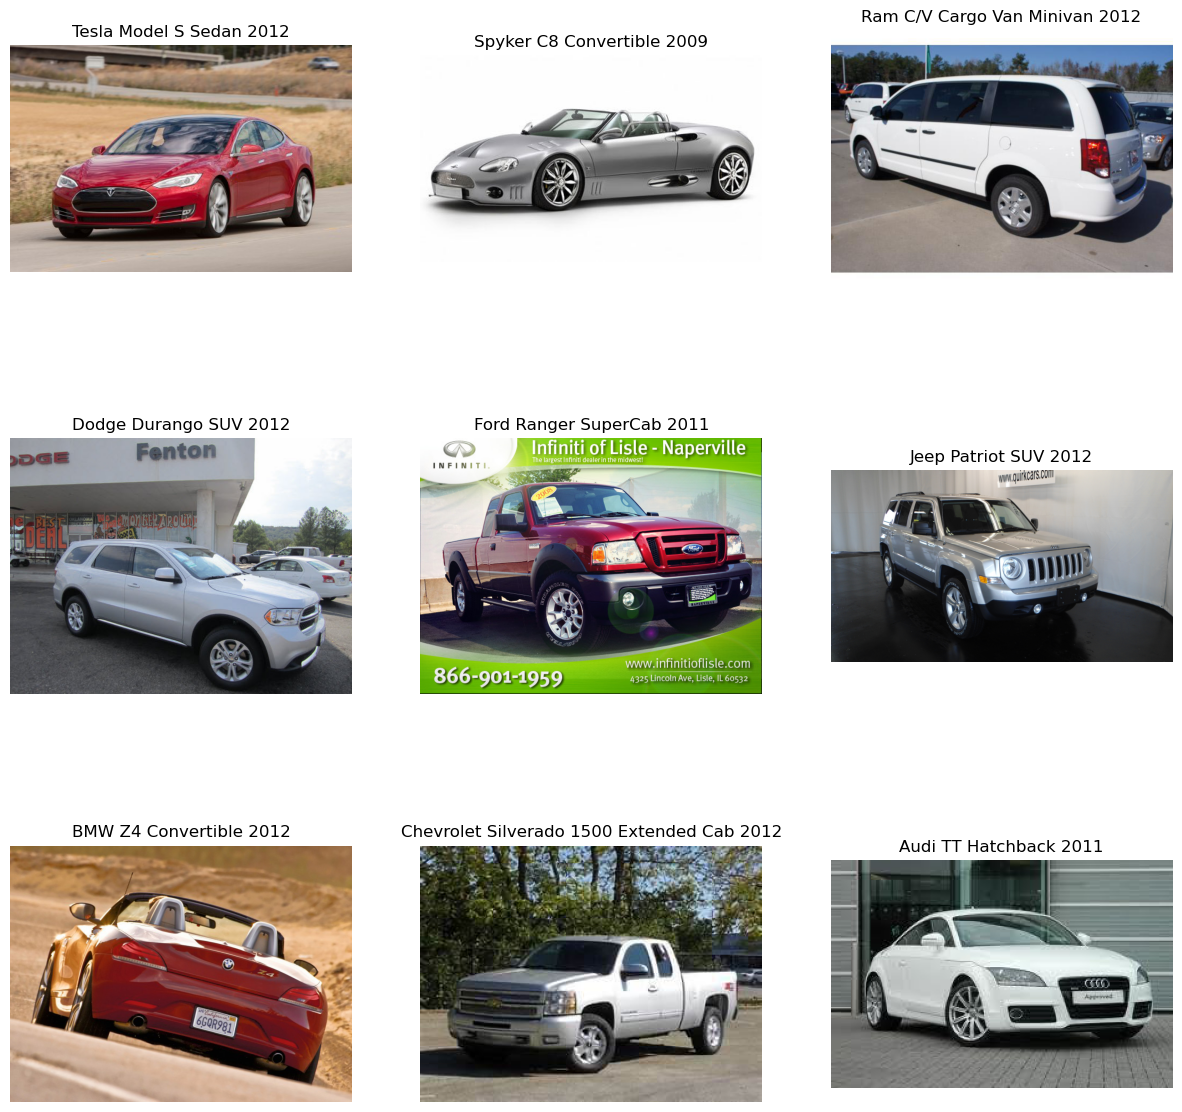

In [5]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

### Подготовим данные  
Создадим dataset и dataloader

In [6]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

In [7]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
import cv2
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import EfficientNet_B0_Weights
import torchvision.transforms as transforms
import torch.nn as nn
import lightning.pytorch as pl
from pytorch_metric_learning import losses, miners
import numpy as np
from tqdm import notebook
import faiss
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [8]:
class CropClassifDataset(Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [9]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [10]:
train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True)

## Построение модели  
В качестве модели, возьмём efficientnet_b0

In [11]:
class CarEmbedder(pl.LightningModule):
    def __init__(self, emb_size=512, learning_rate=3e-4):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Identity()

        self.embedding = nn.Linear(in_features, emb_size)

        # Функция потерь и майнер для hard negative mining
        self.loss_func = losses.TripletMarginLoss(margin=0.2)
        self.miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets='hard')

    def forward(self, x):
        x = self.model(x)
        x = self.embedding(x)
        return x

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self.forward(images)

        hard_pairs = self.miner(embeddings, labels)
        loss = self.loss_func(embeddings, labels, hard_pairs)

        self.log('train_loss', loss, on_step=True, on_epoch=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self.forward(images)

        loss = self.loss_func(embeddings, labels)
        self.log('val_loss', loss, on_epoch=True, sync_dist=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [12]:
pl_model = CarEmbedder(emb_size=512, learning_rate=3e-4)
pl_model.to(device)

checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min',  save_top_k=3)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

torch.set_float32_matmul_precision('high')

trainer = pl.Trainer(max_epochs = 40, accelerator='auto', devices = 'auto', callbacks=[checkpoint_callback, early_stopping, lr_monitor])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model=pl_model, train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 4.0 M  | train
1 | embedding | Linear             | 655 K  | train
2 | loss_func | TripletMarginLoss  | 0      | train
3 | miner     | TripletMarginMiner | 0      | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated model params size (MB)
341       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\zacgr\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
C:\Users\zacgr\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [14]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.10973961651325226    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.10973961651325226}]

На валидационной выборке loss выглядит приемлемо

### Посмотрим на качество.  
Для этого посчитаем эмбеддинги и посмотрим, какие изображения получатся ближе

In [15]:
pl_model.to(device)


def get_embeddings_and_labels(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in notebook.tqdm(dataloader):
            images = batch['image'].to(device)
            lbls = batch['label'].to(device)
            embs = model(images)
            embeddings.append(embs.cpu())
            labels.append(lbls.cpu())
    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()
    return embeddings, labels

train_embeddings, train_labels = get_embeddings_and_labels(pl_model, train_loader)
test_embeddings, test_labels = get_embeddings_and_labels(pl_model, valid_loader)

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

### Посмотрим на "близость" изображений

In [16]:
index = faiss.IndexFlatL2(512)
index.add(train_embeddings.astype(np.float32))

# Поиск ближайших соседей
k = 5
D, I = index.search(test_embeddings.astype(np.float32), k)

In [17]:
def calculate_metrics(I, test_labels, train_labels, k):
    recall_at_k = 0
    precision_at_k = 0
    for i in range(len(test_labels)):
        retrieved_indices = I[i][:k]  # Индексы топ-k ближайших соседей
        retrieved_labels = train_labels[retrieved_indices]
        true_label = test_labels[i]
        
        num_relevant = np.sum(retrieved_labels == true_label)
        
        if num_relevant > 0:
            recall_at_k += 1
        
        precision_at_k += num_relevant / k
    
    recall_at_k = recall_at_k / len(test_labels)
    precision_at_k = precision_at_k / len(test_labels)
    return recall_at_k, precision_at_k

recall_at_1, precision_at_1 = calculate_metrics(I, test_labels, train_labels, k=1)

recall_at_5, precision_at_5 = calculate_metrics(I, test_labels, train_labels, k=5)

print(f"Recall@1: {recall_at_1:.4f}")
print(f"Precision@1: {precision_at_1:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")
print(f"Precision@5: {precision_at_5:.4f}")

Recall@1: 0.4101
Precision@1: 0.4101
Recall@5: 0.6937
Precision@5: 0.3019


Как можно заметить по 1 соседу определяется гораздо хуже, чем по 5

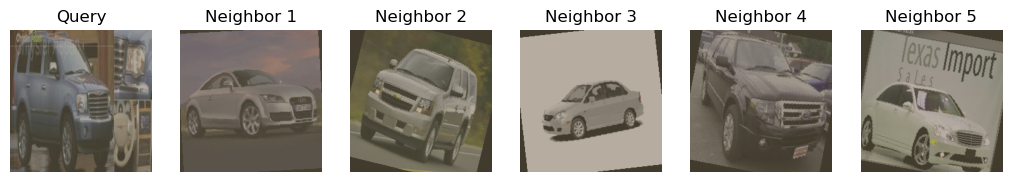

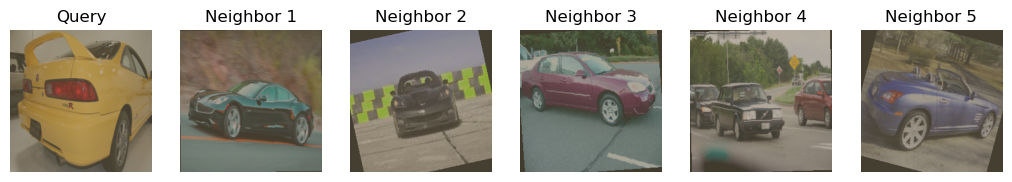

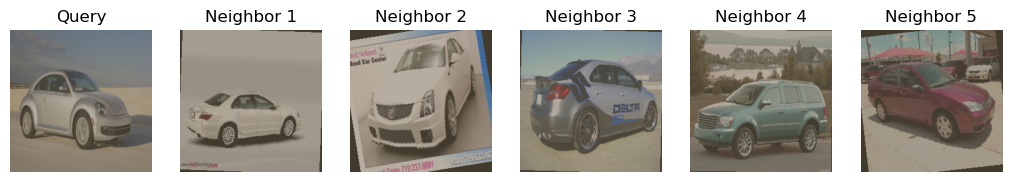

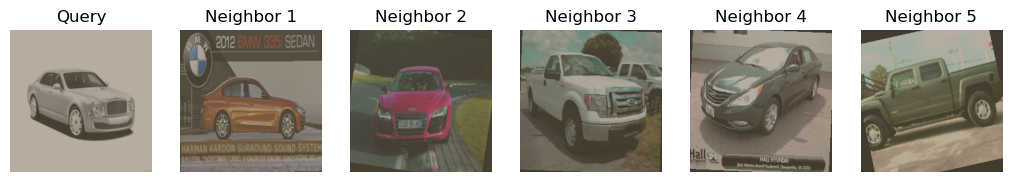

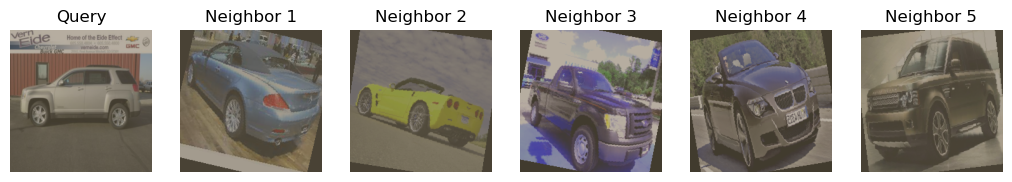

In [18]:
def show_nearest_neighbors(test_dataset, train_dataset, I, num_examples=5):
    for idx in range(num_examples):
        test_sample = test_dataset[idx]
        test_image = test_sample['image'].permute(1, 2, 0).numpy()
        test_image = test_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        test_image = np.clip(test_image, 0, 1)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, k+2, 1)
        plt.imshow(test_image)
        plt.title('Query')
        plt.axis('off')

        for i in range(k):
            train_idx = I[idx][i]
            train_sample = train_dataset[train_idx]
            train_image = train_sample['image'].permute(1, 2, 0).numpy()
            train_image = train_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            train_image = np.clip(train_image, 0, 1)
            plt.subplot(1, k+2, i+2)
            plt.imshow(train_image)
            plt.title(f'Neighbor {i+1}')
            plt.axis('off')
        plt.show()

show_nearest_neighbors(val_dataset, train_dataset, I)

Судя по эмбеддингам модель не очень точно разделяет классы картинок

### Попробуем посмотреть - на что модель обращала внимание при принятии решения

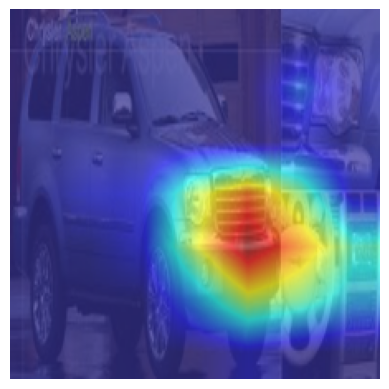

In [19]:
def visualize_gradcam(model, img_tensor, target_layer):
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0))[0]
    rgb_image = img_tensor.permute(1, 2, 0).cpu().numpy()
    rgb_image = rgb_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    rgb_image = np.clip(rgb_image, 0, 1)
    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

test_sample = val_dataset[0]
img_tensor = test_sample['image'].to(device)
visualize_gradcam(pl_model.model, img_tensor, pl_model.model.features[-1])


Как видно - на переднюю часть автомобиля, что логично

### Выполним обучение с другой функцией потерь  
В данном случае применим MultiSimilarityLoss и соответственно MultiSimilarityMiner  
Проделаем все те же шаги, что и для предыдущей модели

In [20]:
class CarEmbedder_another_metric(pl.LightningModule):
    def __init__(self, emb_size=512, learning_rate=3e-4):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Identity()
        
        self.embedding = nn.Linear(in_features, emb_size)
        
        # Инициализируем функцию потерь и майнер
        self.loss_func = losses.MultiSimilarityLoss(alpha=2, beta=50, base=0.5)
        self.miner = miners.MultiSimilarityMiner(epsilon=0.1)
        
    def forward(self, x):
        x = self.model(x)
        x = self.embedding(x)
        return x

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self.forward(images)
        
        # Формируем пары с помощью майнера
        indices_tuple = self.miner(embeddings, labels)
        
        loss = self.loss_func(embeddings, labels, indices_tuple)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        embeddings = self.forward(images)
        
        loss = self.loss_func(embeddings, labels)
        self.log('val_loss', loss, on_epoch=True, sync_dist=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [21]:
pl_model_another_metric = CarEmbedder_another_metric(emb_size=512, learning_rate=3e-4)
pl_model_another_metric.to(device)

checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min',  save_top_k=3)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

torch.set_float32_matmul_precision('high')

trainer_another_metric = pl.Trainer(max_epochs = 40, accelerator='auto', devices = 'auto', callbacks=[checkpoint_callback, early_stopping, lr_monitor])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [22]:
trainer_another_metric.fit(model=pl_model_another_metric, train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | EfficientNet         | 4.0 M  | train
1 | embedding | Linear               | 655 K  | train
2 | loss_func | MultiSimilarityLoss  | 0      | train
3 | miner     | MultiSimilarityMiner | 0      | train
-----------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated model params size (MB)
341       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [23]:
trainer_another_metric.validate(model=pl_model_another_metric, dataloaders=valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.17748543620109558    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.17748543620109558}]

In [24]:
pl_model_another_metric.to(device)


def get_embeddings_and_labels(model, dataloader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in notebook.tqdm(dataloader):
            images = batch['image'].to(device)
            lbls = batch['label'].to(device)
            embs = model(images)
            embeddings.append(embs.cpu())
            labels.append(lbls.cpu())
    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()
    return embeddings, labels

train_embeddings, train_labels = get_embeddings_and_labels(pl_model_another_metric, train_loader)
test_embeddings, test_labels = get_embeddings_and_labels(pl_model_another_metric, valid_loader)


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [25]:
index = faiss.IndexFlatL2(512)  # Размер эмбеддинга 512
index.add(train_embeddings.astype(np.float32))

# Поиск ближайших соседей
k = 5
D, I = index.search(test_embeddings.astype(np.float32), k)

In [26]:
def calculate_metrics(I, test_labels, train_labels, k):
    recall_at_k = 0
    precision_at_k = 0
    for i in range(len(test_labels)):
        retrieved_indices = I[i][:k]  # Индексы топ-k ближайших соседей
        retrieved_labels = train_labels[retrieved_indices]
        true_label = test_labels[i]
        
        num_relevant = np.sum(retrieved_labels == true_label)
        
        if num_relevant > 0:
            recall_at_k += 1
        
        precision_at_k += num_relevant / k
    
    recall_at_k = recall_at_k / len(test_labels)
    precision_at_k = precision_at_k / len(test_labels)
    return recall_at_k, precision_at_k

recall_at_1, precision_at_1 = calculate_metrics(I, test_labels, train_labels, k=1)

recall_at_5, precision_at_5 = calculate_metrics(I, test_labels, train_labels, k=5)

print(f"Recall@1: {recall_at_1:.4f}")
print(f"Precision@1: {precision_at_1:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")
print(f"Precision@5: {precision_at_5:.4f}")

Recall@1: 0.3149
Precision@1: 0.3149
Recall@5: 0.5881
Precision@5: 0.2189


Здесь качество получилось чуть похуже, однако общая картина та же самая

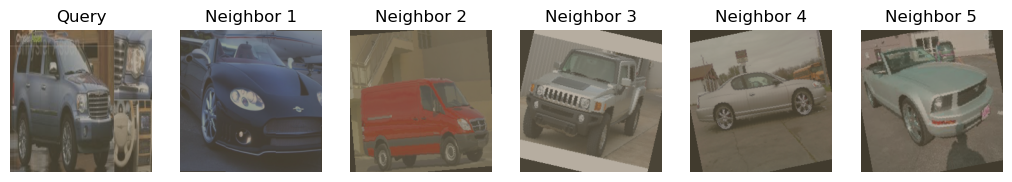

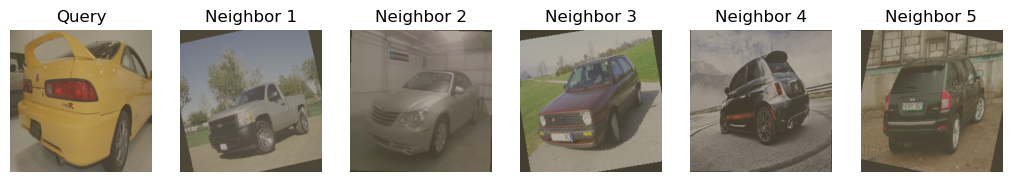

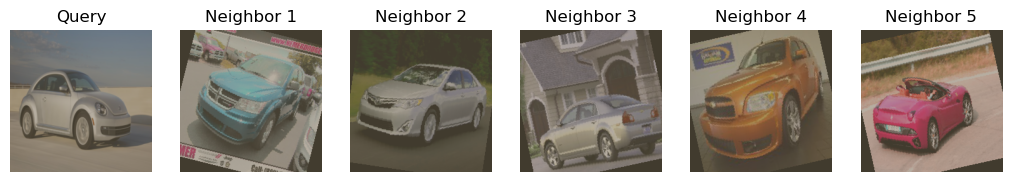

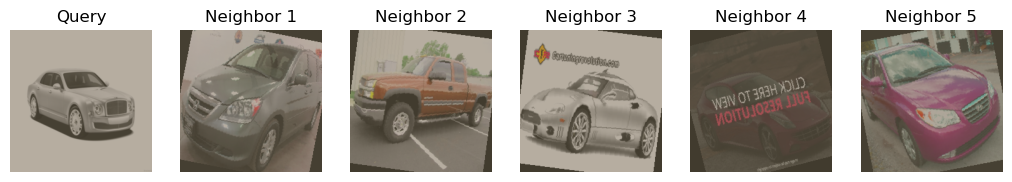

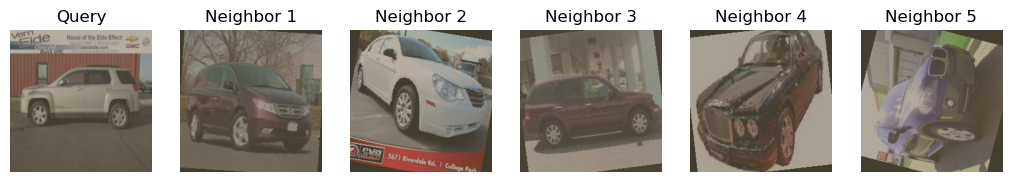

In [27]:
def show_nearest_neighbors(test_dataset, train_dataset, I, num_examples=5):
    for idx in range(num_examples):
        test_sample = test_dataset[idx]
        test_image = test_sample['image'].permute(1, 2, 0).numpy()
        test_image = test_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        test_image = np.clip(test_image, 0, 1)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, k+2, 1)
        plt.imshow(test_image)
        plt.title('Query')
        plt.axis('off')

        for i in range(k):
            train_idx = I[idx][i]
            train_sample = train_dataset[train_idx]
            train_image = train_sample['image'].permute(1, 2, 0).numpy()
            train_image = train_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            train_image = np.clip(train_image, 0, 1)
            plt.subplot(1, k+2, i+2)
            plt.imshow(train_image)
            plt.title(f'Neighbor {i+1}')
            plt.axis('off')
        plt.show()

show_nearest_neighbors(val_dataset, train_dataset, I)

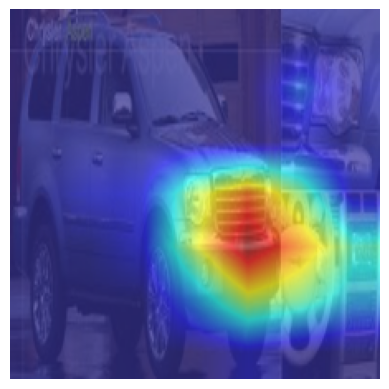

In [28]:
def visualize_gradcam(model, img_tensor, target_layer):
    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0))[0]
    rgb_image = img_tensor.permute(1, 2, 0).cpu().numpy()
    rgb_image = rgb_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    rgb_image = np.clip(rgb_image, 0, 1)
    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

test_sample = val_dataset[0]
img_tensor = test_sample['image'].to(device)
visualize_gradcam(pl_model.model, img_tensor, pl_model.model.features[-1])


Эта модель также "смотрит" на капот и радиаторную решётку

### Выводы

Результаты экспериментов показали, что такой вариант модели может быть эффективным для задачи Metric Learning, однако для достижения лучшего качества очень важен подбор Loss функции и параметров обучения.